Hope this is helpful.  Some of the code might seem "odd", but it is being used to set up models in FSL.
Here's what to do (I think)
First, install fitlins.  I just followed the instructions for Manually Prepared Environment
If you aren't familiar with environments, let Jeanette know and I can try to help.

Next, clone the model zoo repo, because Chris has put some BIDS light data there we can use 

Last, after you clone the repo, say, for example, you'd like to work with ds005, then cd into that directory and run

datalad install -r .

Ah, shoot, I guess you'll need to also install datalad.  I'm guessing there are instructions to follow online.  I don't recall how I did it, but the super nerds will be able to help you.

Last, in your repo, if you change the name of a variable in a convolve transform to something different than the input, my code breaks.  I'll try to fix it soon, but meanwhile just don't do that :)

In [1]:
from bids.layout import BIDSLayout
from bids.layout.writing import build_path
from bids.modeling import BIDSStatsModelsGraph
from bids.modeling import transformations as tm
import sys
import pandas as pd
from bids.variables import DenseRunVariable
import numpy as np
from nilearn.plotting import plot_design_matrix,  plot_contrast_matrix
from itertools import chain
from copy import deepcopy
import matplotlib.pyplot as plt
import json



/Users/jeanettemumford/miniconda3/envs/fitlins/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:

def snake_to_camel(string):
    words = string.split('_')
    return words[0] + ''.join(word.title() for word in words[1:])


def trim_instructions(instructions):
    instructions = instructions.copy()
    transformation_names = [val['name'] for val in instructions]
    not_convolve = [
        i for i,x in enumerate(transformation_names) if x != 'Convolve'
    ]
    convolve = [
        i for i,x in enumerate(transformation_names) if x == 'Convolve'
    ]
    trimmed_instructions = [
        instructions[i] for i in not_convolve
    ]
    convolve_regs = [
        instructions[i]['input'] for i in convolve
    ]
    return trimmed_instructions, convolve_regs


def categorize_regressors(node, convolve_regs, trans_out):
    """
    Three sets of regressors, main design matrix regressors involve
    those to be convolved and not convolved, but used in contrast, last set is
    confound regressors (not used in contrasts and not convolved)
    """
    import itertools
    # Just in case they don't use x (although they should)
    model_name = list(node.model.keys())[0]
    specified_reg_name_list = node.model.get(model_name).copy()
    specified_reg_names = set(specified_reg_name_list) - {1}
    dense_reg_options = {
        key for key, item in trans_out.variables.items() if 
        isinstance(item, DenseRunVariable)
    }

    contrast_regs = set()
    for contrast in node.contrasts:
        contrast_regs_loop = set(contrast['condition_list'])
        contrast_regs = contrast_regs | contrast_regs_loop
    
    convolve_regs = set(itertools.chain(*convolve_regs))
    confound_regs = specified_reg_names & (dense_reg_options - contrast_regs)
    main_convolve_regs = specified_reg_names & convolve_regs
    main_no_convolve_regs = specified_reg_names & (contrast_regs - convolve_regs)
    regs_missing = (specified_reg_names - 
        (confound_regs | main_convolve_regs | main_no_convolve_regs))
    contrast_reg_missing = contrast_regs - specified_reg_names
    # FIX, this breaks if they changed name in output of convolve
    if regs_missing:
        raise ValueError([f'X specification includes variable(s) {regs_missing}, '
                'but these were either not data matrix or were not convolved.'])
    if contrast_reg_missing:
        raise ValueError([f'Contrast specified refers to {contrast_reg_missing}, '
                'but this is not defined in the model.'])

    #put back in order so users are not confused
    confound_regs_list = [
        name for name in specified_reg_name_list if name in confound_regs
    ]
    convolve_regs_list = [
        name for name in convolve_regs if name in main_convolve_regs
    ]
    no_convolve_reg_list = [
        name for name in specified_reg_name_list if name in main_no_convolve_regs
    ]
    regs_categorized = {
        "confound_regs": confound_regs_list,
        "convolve_regs": convolve_regs_list,
        "no_convolve_regs": no_convolve_reg_list
    }
    return regs_categorized


def make_run_level_des_files(trans_out, node, convolve_regs):   
    if len(node.model) > 1:
        sys.exit(
            f"More than one model was entered into Node {node.name}. " +
            "Please repair model specification."
        )

    regs_categorized = categorize_regressors(node, convolve_regs, trans_out)

    confound_regmat = pd.DataFrame()
    for confound_reg in regs_categorized['confound_regs']:
        confound_regmat = pd.concat(
            [confound_regmat, trans_out.variables.get(confound_reg).values],
            axis=1
        )
    # Fix NA that can pop up in first TR.  MAY NEED TO CHANGE LATER!!
    idx, _ = np.where(confound_regmat.isna())
    if any(idx>0):
        raise ValueError(['Regressor from data matrix has NaNs beyond first' 
            'time point']) 
    
    confound_regmat = confound_regmat.fillna(0)
    
    all_regs = {'confounds': confound_regmat}
    
    for reg_to_convolve in regs_categorized['convolve_regs']:
        reg_info = trans_out.variables.get(reg_to_convolve).to_df(entities=False)
        sparse_3col = reg_info[['onset', 'duration', 'amplitude']]
        all_regs[reg_to_convolve] = sparse_3col
        
    for reg_no_convolve in regs_categorized['no_convolve_regs']:
        reg_info = pd.DataFrame(trans_out.variables.get(reg_no_convolve).values)
        all_regs[reg_no_convolve] = reg_info
    return all_regs


def run_node_3col_grabber(graph):
    collection_pattern = ['sub-{subject}[_ses-{session}][_task-{task}][_run-{run}]']
    for node in graph.nodes.values():
        level = node.level

        if level == "run":
            run_trans = node.transformations.copy()
            apply_trans = tm.TransformerManager(run_trans['transformer'])

            reg_info_collections ={}

            for collection in node._collections:
                collection_label = build_path(
                    collection.entities, collection_pattern, strict=False
                )
                trimmed_instructions, convolve_regs = trim_instructions(
                    run_trans['instructions']
                )
                trans_out = apply_trans.transform(
                    collection.clone(), trimmed_instructions
                )
                reg_info = make_run_level_des_files(
                     trans_out, node, convolve_regs
                )
                reg_info_collections[collection_label] = reg_info
    return reg_info_collections


# swiped from LoadBIDSModel
# Can't use directly because _load_run_level writes out files (only bit I deleted)
def load_graph(graph, node=None, inputs=None, **filters):
    if node is None:
        node = graph.root_node

    specs = node.run(inputs, group_by=node.group_by, **filters)
    outputs = list(chain(*[s.contrasts for s in specs]))

    base_entities = graph.model["input"]

    all_specs = {
        node.name: [
            {
                'contrasts': [c._asdict() for c in spec.contrasts],
                'entities': {**base_entities, **spec.entities},
                'level': spec.node.level,
                'X': spec.X,
                'name': spec.node.name,
                'model': spec.node.model,
                # Metadata is only used in higher level models; save space
                'metadata': spec.metadata if spec.node.level != "run" else None,
            }
            for spec in specs
        ]
    }

    for child in node.children:
        all_specs.update(
            load_graph(graph, child.destination, outputs, **child.filter)
        )

    return all_specs



In [24]:
root = '/Users/jeanettemumford/Dropbox/Research/Projects/Fsf_converter/ModelZoo/model-zoo/ds005/ds000005'
database_path = '/Users/jeanettemumford/Dropbox/Research/Projects/Fsf_converter/ModelZoo/model-zoo/ds005/dbcache'
reset_database = True
model_path = '/Users/jeanettemumford/Dropbox/Research/Projects/Fsf_converter/ModelZoo/my_models/model-ds0005_openfmri_model_twp_grp_diff_smdl.json'



In [25]:
layout = BIDSLayout(
        root = root,
        database_path=database_path,
        reset_database=reset_database
)

graph = BIDSStatsModelsGraph(layout, model_path)
graph.load_collections(scan_length=480)    



In [26]:
reg_info_collections = run_node_3col_grabber(graph)


In [27]:
print(reg_info_collections.keys())

dict_keys(['sub-01_task-mixedgamblestask_run-1', 'sub-01_task-mixedgamblestask_run-2', 'sub-01_task-mixedgamblestask_run-3', 'sub-02_task-mixedgamblestask_run-1', 'sub-02_task-mixedgamblestask_run-2', 'sub-02_task-mixedgamblestask_run-3', 'sub-03_task-mixedgamblestask_run-1', 'sub-03_task-mixedgamblestask_run-2', 'sub-03_task-mixedgamblestask_run-3', 'sub-04_task-mixedgamblestask_run-1', 'sub-04_task-mixedgamblestask_run-2', 'sub-04_task-mixedgamblestask_run-3'])


In [28]:
print(reg_info_collections['sub-01_task-mixedgamblestask_run-1'].keys())

for key, value in reg_info_collections['sub-01_task-mixedgamblestask_run-1'].items():
    print(key)
    print(value)

dict_keys(['confounds', 'distance from indifference', 'loss', 'all_trials', 'gain'])
confounds
Empty DataFrame
Columns: []
Index: []
distance from indifference
    onset  duration  amplitude
0     0.0         3    -0.0814
1     4.0         3    -0.4147
2     8.0         3     0.2519
3    18.0         3    -0.0814
4    24.0         3    -0.0814
..    ...       ...        ...
81  458.0         3     0.5853
82  462.0         3     0.2519
83  466.0         3    -0.0814
84  470.0         3    -0.4147
85  474.0         3    -0.0814

[86 rows x 3 columns]
loss
    onset  duration  amplitude
0     0.0         3   2.546512
1     4.0         3  -0.453488
2     8.0         3   2.546512
3    18.0         3   3.546512
4    24.0         3  -7.453488
..    ...       ...        ...
81  458.0         3   5.546512
82  462.0         3  -0.453488
83  466.0         3  -3.453488
84  470.0         3  -0.453488
85  474.0         3   1.546512

[86 rows x 3 columns]
all_trials
    onset  duration  amplitude
0  

In [29]:
all_specs = load_graph(graph, node=None, inputs=None)

In [30]:
print(all_specs['run_within_subject'][0])
#print(all_specs[0])

{'contrasts': [{'name': 'neg_loss_parametric', 'conditions': ['loss'], 'weights': [-1], 'test': 't', 'entities': {'run': 1, 'subject': '01', 'contrast': 'neg_loss_parametric'}}], 'entities': {'task': 'mixedgamblestask', 'subject': '01', 'run': 1}, 'level': 'run', 'X':      all_trials      gain      loss  distance from indifference
0      0.000864 -0.004630  0.002181                   -0.000079
1      0.017514 -0.097264  0.045131                   -0.001358
2      0.255692 -1.421978  0.649814                   -0.020960
3      0.581643 -3.268537  1.425435                   -0.053587
4      0.769143 -4.794845  1.184361                   -0.148505
..          ...       ...       ...                         ...
235    0.826649  3.221939 -2.032576                    0.028207
236    0.798896  0.424372 -2.203717                   -0.136800
237    0.788930 -2.512316 -1.524280                   -0.285794
238    0.762143 -3.284466 -0.390405                   -0.277189
239    0.761435 -2.905342  

Model run_within_subject for {'task': 'mixedgamblestask', 'subject': '01', 'run': 1}
contrasts: [{'name': 'neg_loss_parametric', 'conditions': ['loss'], 'weights': [-1], 'test': 't', 'entities': {'run': 1, 'subject': '01', 'contrast': 'neg_loss_parametric'}}]


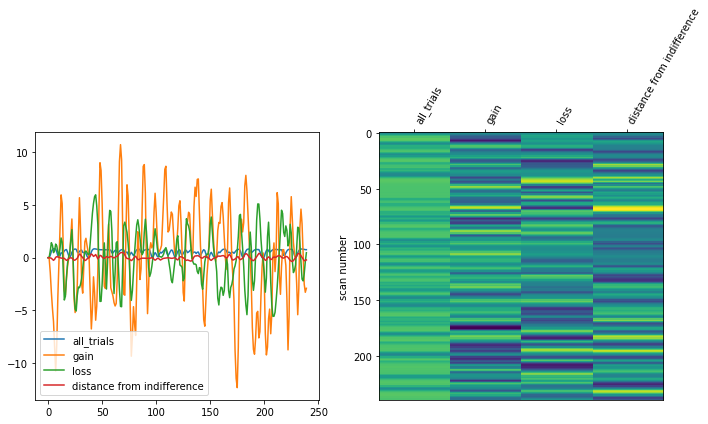

In [31]:
import matplotlib.pyplot as plt

for key, cur_spec in all_specs.items():
    if cur_spec[0]['level'] == 'run':
        print(f'Model {key} for {cur_spec[0]["entities"]}')
        print(f'contrasts: {cur_spec[0]["contrasts"]}')
        fig, (ax1, ax2) = plt.subplots(figsize=(10, 6), nrows=1, ncols=2)
        cur_spec[0]['X'].plot(ax=ax1)
        ax1.legend(loc='lower left')
        plot_design_matrix(cur_spec[0]['X'], ax=ax2)
        plt.show()


In [32]:

for lev_key, lev_info in all_specs.items():
    cur_level = lev_info[0]['level']
    if cur_level != 'run':
        print(f'Level {cur_level}')
        print(f'Model {lev_info[0]["name"]}')
        print(lev_info[0]['X'])
        print(lev_info[0]['contrasts'])

Level subject
Model combine_runs_within_subject
   neg_loss_parametric
0                    1
1                    1
2                    1
[{'name': 'neg_loss_parametric', 'conditions': ['neg_loss_parametric'], 'weights': [1], 'test': 't', 'entities': {'subject': '01', 'contrast': 'neg_loss_parametric'}}]
Level dataset
Model group_average
   sex.M  sex.F
0    1.0    0.0
1    0.0    1.0
2    0.0    1.0
3    1.0    0.0
[{'name': 'female_gt_male', 'conditions': ['sex.M', 'sex.F'], 'weights': [-1, 1], 'test': 't', 'entities': {'contrast': 'female_gt_male'}}, {'name': 'male_gt_female', 'conditions': ['sex.M', 'sex.F'], 'weights': [1, -1], 'test': 't', 'entities': {'contrast': 'male_gt_female'}}]


In [ ]:
# read in json and write back out to fix ugliness
import json
with open(model_path, 'r') as f:
  mod_json = json.load(f)
print(mod_json)
with open(model_path, 'w') as fp:
    json.dump(mod_json, fp, indent=4)